In [16]:
import yaml
import numpy as np
from TraceSimulator import LongTraceSimulator
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import fftconvolve


def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('/home/dwong/DELight_mtr/trigger_study/archive/wk11/config.yaml')
lts = LongTraceSimulator(config)


sampling_frequency = 3906250
vac_template = np.load("templates/vac_ch_template.npy")
template = np.load("templates/sub_ch_template.npy")
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")
length = len(template)

if length%2==0:
    noise_psd_unfolded = np.concatenate(([np.inf],
                                                noise_psd[1:-1]/2,
                                                [noise_psd[-1]],
                                                noise_psd[-2:0:-1]/2))
else:
    noise_psd_unfolded = np.concatenate(([np.inf],
                                                noise_psd[1:]/2,
                                                noise_psd[-1:0:-1]/2))
    
template_fft = fft(template)/sampling_frequency

kernel_fft = template_fft.conjugate() / noise_psd_unfolded
kernel_normalization = np.real(np.dot(kernel_fft, template_fft))*sampling_frequency/3276800
filter_kernel = kernel_fft / kernel_normalization
kernel_td = np.real(ifft(filter_kernel)) * sampling_frequency


In [2]:
trace, idx= lts.generate(
            E=70000,
            x=-94, y=0, z=-1800,
            no_noise=False,
            type_recoil='ER',
            quantize=True,
            phonon_only=False
        )
trace = trace[0]

32768


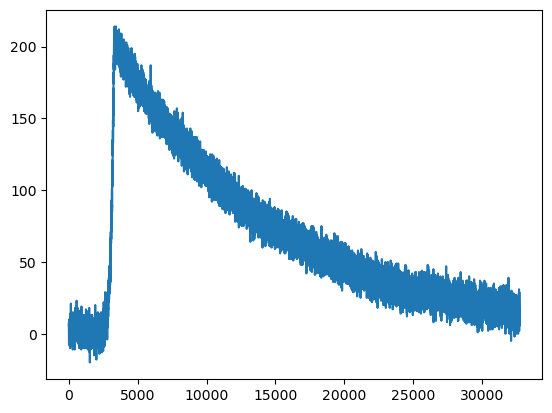

In [3]:
example = trace[7][idx:idx+32768]
print(len(example))
plt.plot(example)

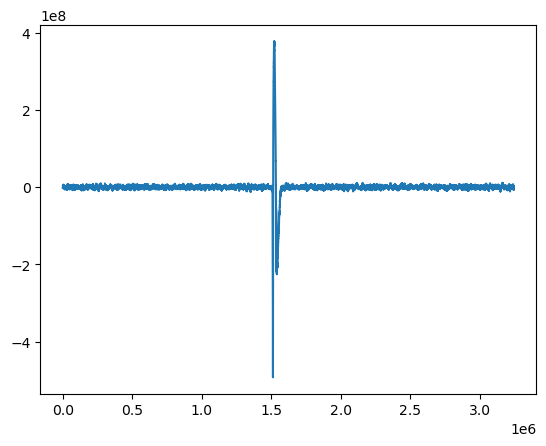

In [4]:
filtered_trace = fftconvolve(trace[7], kernel_td[::-1], mode='valid')
plt.plot(filtered_trace)

In [24]:
example = trace[7][idx:idx+32768]

allowed_shift_range=None

trace_fft = fft(example, axis=-1)/sampling_frequency # V
trace_filtered = filter_kernel * trace_fft
trace_filtered_td = np.real(
    ifft(trace_filtered, axis=-1)
) * sampling_frequency

chi0 = np.real((trace_fft.conj() * trace_fft / noise_psd_unfolded).sum()) * sampling_frequency / length
chit_withdelay = (trace_filtered_td ** 2) * kernel_normalization
chi = chi0 - chit_withdelay

if allowed_shift_range is None:
    ind = np.arange(len(chi))
else:
    ind = np.concatenate((np.arange(length+allowed_shift_range[0], length),
                            np.arange(allowed_shift_range[1]+1)))

best_ind = ind[np.argmin(chi[ind], axis=-1)]

amp = trace_filtered_td[best_ind]
chisq = chi[best_ind]/(length-3)
t0 = best_ind if best_ind<length//2 else best_ind-length
        


In [25]:
amp

218.9051208594526

In [11]:
long_max

310415214.2389279

In [39]:
sampling_frequency / (kernel_normalization * 32768)

92.9725916327735

In [7]:
example = trace[7]

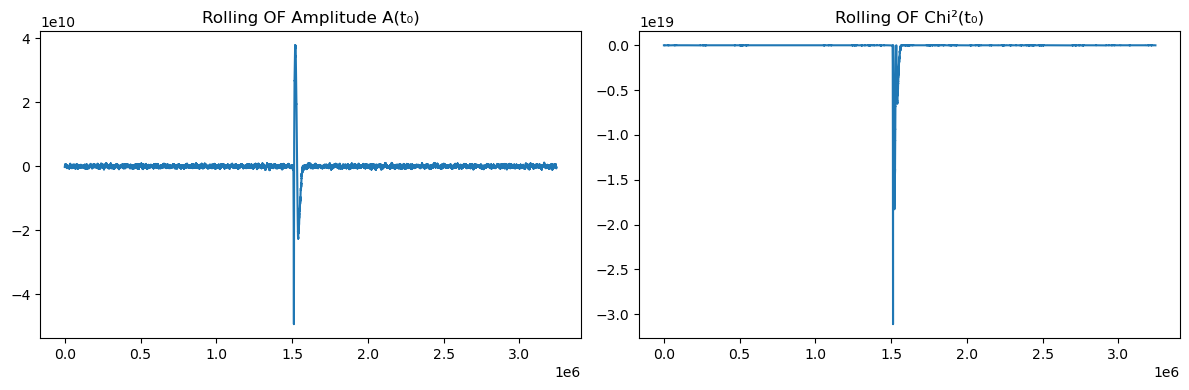

In [17]:
# Rolling Optimum Filter (matched filter, time-domain)

# 1. Flip kernel for matched filtering
kernel_flipped = kernel_td[::-1]  # matched filter convolution

# 2. Amplitude A(t₀) by convolving trace with kernel
amp_t0_rolling = np.convolve(example, kernel_flipped, mode='valid')  # len = len(example) - len(kernel_td) + 1

# 3. Rolling power (approx chi0)
window_power = np.convolve(example**2, np.ones(len(kernel_td)), mode='valid')

# 4. Chi-squared(t₀) = trace power - A(t₀)^2 * norm
chi2_t0_rolling = window_power - amp_t0_rolling**2 * kernel_normalization

# Optional visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(amp_t0_rolling)
plt.title("Rolling OF Amplitude A(t₀)")
plt.subplot(1, 2, 2)
plt.plot(chi2_t0_rolling)
plt.title("Rolling OF Chi²(t₀)")
plt.tight_layout()
plt.show()

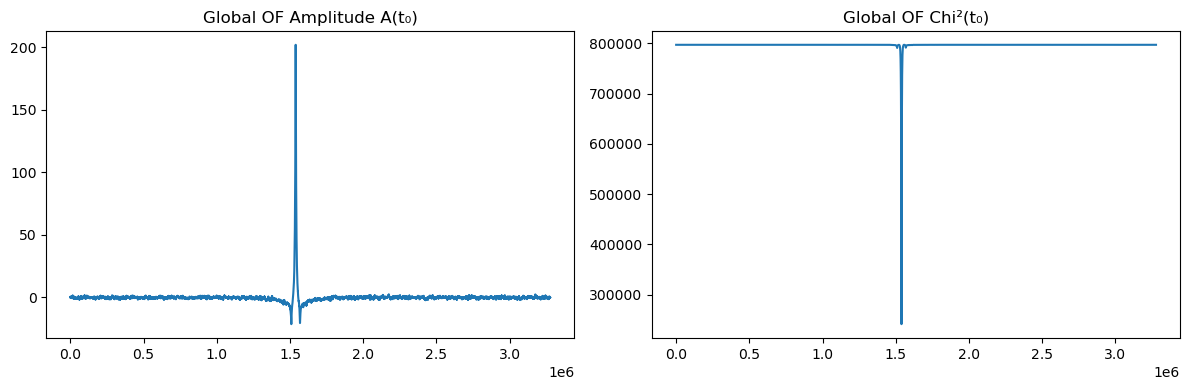

In [9]:



# Global Optimum Filter (frequency-domain)

L_example = len(example)
L_temp = len(template)

# 1. Pad template to match trace
template_padded = np.pad(template, (0, L_example - L_temp))

# 2. FFT of template and trace
template_fft = fft(template_padded) / sampling_frequency
example_fft = fft(example) / sampling_frequency

# 3. Unfold noise PSD to full length
if L_example % 2 == 0:
    noise_psd_unfolded = np.concatenate((
        [1e30],
        noise_psd[1:-1] / 2,
        [noise_psd[-1]],
        noise_psd[-2:0:-1] / 2
    ))
else:
    noise_psd_unfolded = np.concatenate((
        [1e30],
        noise_psd[1:] / 2,
        noise_psd[-1:0:-1] / 2
    ))
noise_psd_unfolded = np.pad(noise_psd_unfolded, (0, L_example - len(noise_psd_unfolded)))

# Avoid divide-by-zero or inf
noise_psd_unfolded = np.where(noise_psd_unfolded == 0, 1e30, noise_psd_unfolded)

# 4. Build filter kernel
kernel_fft = template_fft.conjugate() / noise_psd_unfolded
kernel_normalization = np.real(np.dot(kernel_fft, template_fft)) * sampling_frequency / L_example
filter_kernel_fft = kernel_fft / kernel_normalization

# 5. Apply to full trace
filtered_fft = example_fft * filter_kernel_fft
amp_t0_global = np.real(ifft(filtered_fft)) * sampling_frequency

# 6. Estimate chi^2(t0)
power_fft = example_fft.conj() * example_fft / noise_psd_unfolded
chi0_global = np.real(np.sum(power_fft)) * sampling_frequency / L_example
chi2_t0_global = chi0_global - amp_t0_global**2 * kernel_normalization

# Optional visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(amp_t0_global)
plt.title("Global OF Amplitude A(t₀)")
plt.subplot(1, 2, 2)
plt.plot(chi2_t0_global)
plt.title("Global OF Chi²(t₀)")
plt.tight_layout()
plt.show()

In [12]:
kernel_normalization = np.real(np.dot(kernel_fft, template_fft)) * sampling_frequency / 3276800


In [13]:
chi2_t0_rolling = window_power - amp_t0_rolling**2 * kernel_normalization


In [14]:
print("Global norm:", kernel_normalization_global)
print("Rolling norm:", kernel_normalization_used_for_td)


NameError: name 'kernel_normalization_global' is not defined

In [15]:
from numpy import allclose

i_roll = np.argmax(np.abs(amp_t0_rolling))
i_glob = np.argmax(np.abs(amp_t0_global))

print(f"Rolling peak: A = {amp_t0_rolling[i_roll]:.3g} at t0 = {i_roll}")
print(f"Global  peak: A = {amp_t0_global[i_glob]:.3g} at t0 = {i_glob}")

print("Amplitudes similar?", allclose(amp_t0_rolling[i_roll], amp_t0_global[i_glob], rtol=0.05))


Rolling peak: A = -4.93e+08 at t0 = 1512152
Global  peak: A = 202 at t0 = 1538717
Amplitudes similar? False
